In [1]:
import pickle
import os 
import netCDF4 as netcdf
import skimage
import numpy as np
import torch 
import matplotlib.pyplot as plt


def data_processing(data,longitude,latitude,max_models = 15):
    """ Process the data: statically relevant climate models (nb_runs > 3),
                            upscaling (from 0.25 to 0.5), 
                            cropping (remove latitude > 60),
                            time period focus (from 1981 until 2019)

        Args: 
            data: Dictionary of raw data (indexed by models and subdictionary indexed by runs)
            longitude, latitude: np.array, longitude and latitude coordinates
            max_models: integer, maximum number of climate models (default is 15)
            
        
        Returns:
            data_processed: upscaled data
            notnan_idx, nan_idx: non nan indices and nan indices i
    """
    # first filter out the models that contain less than 3 ensemble members 
    data_processed = {}

    # record nan indices as the union of nans on each map
    nan_idx = []


    for idx_m,m in enumerate(data.keys()):
        
        if (len(data[m].keys()) > 3) and (idx_m < max_models):

            data_processed[m] = data[m].copy()
            
            for idx_r, r in enumerate(data[m].keys()):

                # Upscaling of raw data 
                data_processed[m][r] = skimage.transform.downscale_local_mean(data_processed[m][r][131:,:,:],(1,2,2))
                data_processed[m][r] = data_processed[m][r][:,latitude<=60,:]

                # capture nan indices and record the union of nans
                nan_idx_tmp = list(np.where(np.isnan(data_processed[m][r][0,:,:].ravel())==True)[0])
                nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

    # get longitude and latitude size
    lon_size = longitude.shape[0]
    lat_size = latitude[latitude <=60].shape[0]
    
    # define not nan indices (useful to ease the computations)
    notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

    return data_processed, notnan_idx, nan_idx

#######  compute anomaly scaler and forced response ########
def compute_anomalies_and_scalers(data, lon_size, lat_size, nan_idx, time_period=34):
    """ Compute anomalies with respect to a given reference period.

        Args:
            - data: dictionary, preprocessed data
            - lon_size, lat_size: longitude size and latitude size
            - nan_idx: list of integers, list of nan indices in the flatten array
            - time_period: Int, time series lentgh (target period 1981-2015)
            
        Return:
            - data_reshaped: dictionary of reshaped data (stacked across runs)
            - means, vars: dictionaries of means and variances
    """
    data_reshaped = {}
    means = {}
    vars = {}

    for idx_m,m in enumerate(data.keys()):
        data_reshaped[m] = np.zeros((len(data[m].keys()),time_period, lat_size*lon_size))
    
        for idx_r, r in enumerate(data[m].keys()):

            # flatten the data
            data_reshaped[m][idx_r,:,:] = data[m][r].copy().reshape(time_period, lat_size*lon_size)

            # replace continent's grid cell values with NaNs
            data_reshaped[m][idx_r,:,nan_idx] = float('nan')


        # compute the mean 
        means[m] = np.nanmean(data_reshaped[m],axis=0)

        # compute the variance
        vars[m] = np.nanvar(data_reshaped[m],axis=0)
        
    return data_reshaped, means, vars


def compute_forced_response(data, lon_size, lat_size, nan_idx, time_period=34):
    """ Compute forced response.

        Args:
            - data: dictionary, preprocessed data
            - lon_size, lat_size: Integer, longitude size and latitude size
            - nan_idx: list of integers, list of nan indices in the flatten array
            - time_period: Int, time series lentgh (target period 1981-2015)
            
        Return:
            - data_anomalies: dictionary of centered (according to a specific definition) data
    """
    # compute the forced response
    data_forced_response = {}

    for idx_m,m in enumerate(data.keys()):
        
        data_forced_response[m] = np.zeros((len(data[m].keys()),time_period, lat_size*lon_size))
        y_tmp = np.zeros((len(data[m].keys()),time_period, lat_size*lon_size))
    
        for idx_r, r in enumerate(data[m].keys()):

            # flatten the data
            y_tmp[idx_r,:,:] = data[m][r].copy().reshape(time_period, lat_size*lon_size)

            # replace continent's grid cell values with NaNs
            y_tmp[idx_r,:,nan_idx] = float('nan')
    
        # compute mean reference
        mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)

        # copmpute forced response (the same for each run)
        for idx_r, r in enumerate(data[m].keys()):              
            data_forced_response[m][idx_r,:,:] = mean_spatial_ensemble

    return data_forced_response

###################### Load longitude and latitude  (ADJUST THE PATH) ######################
with open('../data/lon.npy', 'rb') as f:
    lon = np.load(f)

with open('../data/lat.npy', 'rb') as f:
    lat = np.load(f)

# crop the latitude
lat_grid, lon_grid = np.meshgrid(lat[lat<=60], lon, indexing='ij')

lat_size = lat_grid.shape[0]
lon_size = lon_grid.shape[1]


time_period = 34


# Load data (ADJUST THE PATH)
with open('../data/ssp585_time_series.pkl', 'rb') as f:
    data = pickle.load(f)

# Load the data, and process it
data_processed, notnan_idx, nan_idx = data_processing(data, lon, lat,max_models=100)
x, means, vars = compute_anomalies_and_scalers(data_processed, lon_size, lat_size, nan_idx, time_period=34)
y = compute_forced_response(data_processed, lon_size, lat_size, nan_idx, time_period=34)

/tmp/ipykernel_48755/791045794.py:89: RuntimeWarning: Mean of empty slice
  means[m] = np.nanmean(data_reshaped[m],axis=0)
/tmp/ipykernel_48755/791045794.py:92: RuntimeWarning: Degrees of freedom <= 0 for slice.
  vars[m] = np.nanvar(data_reshaped[m],axis=0)
/tmp/ipykernel_48755/791045794.py:126: RuntimeWarning: Mean of empty slice
  mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)


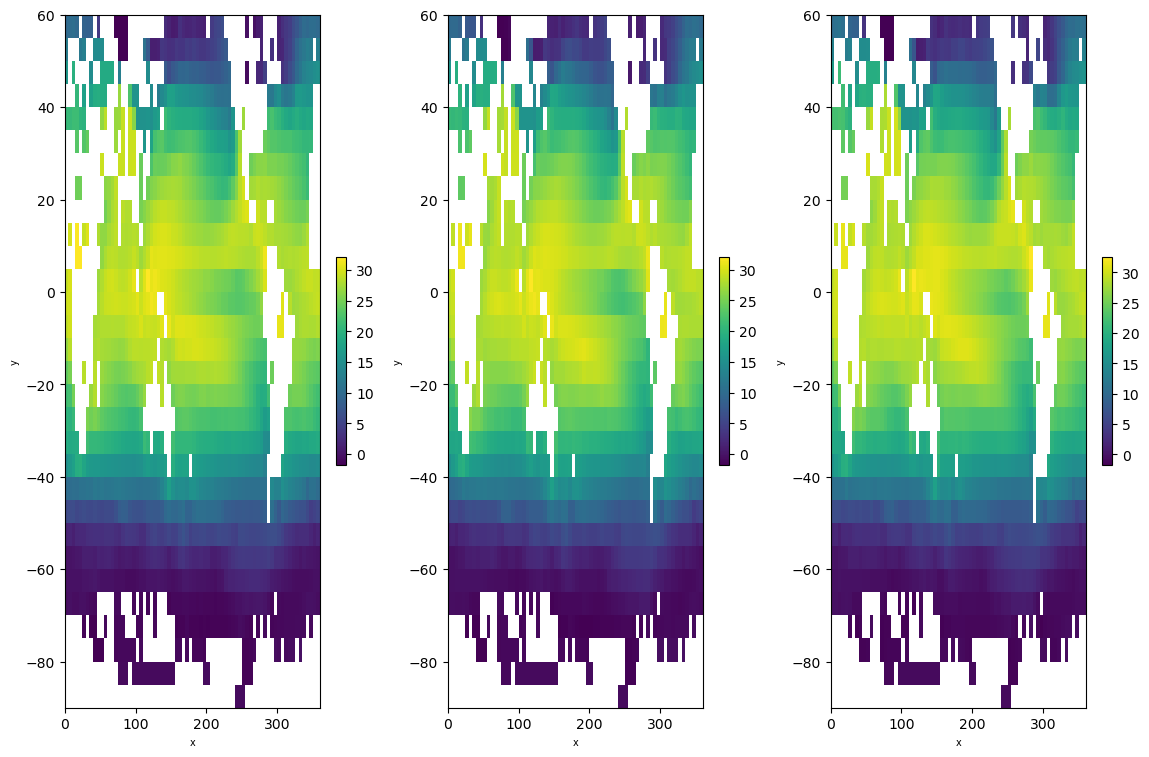

In [2]:
# define beta to plot
idx_m = 0
idx_run = 2

processed_model_names = list(data_processed.keys())
m = processed_model_names[idx_m]


lst_run = list(data_processed[m].keys())
r = lst_run[idx_run]


sst0 = data_processed[m][r][0]
# sst0[nan_idx] = float('nan')
sst0 = sst0.reshape(lat_size,lon_size)


sst1 = data_processed[m][r][13]
# sst1[nan_idx] = float('nan')
sst1 = sst1.reshape(lat_size,lon_size)

sst2 = data_processed[m][r][24]
# sst2[nan_idx] = float('nan')
sst2 = sst2.reshape(lat_size,lon_size)

fig0 = plt.figure(figsize=(14,9))           

ax0 = fig0.add_subplot(1, 3, 1)        
# ax0.set_title(r'$\beta \geq 0$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,sst0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(1, 3, 2)        
# ax0.set_title(r'$\beta \leq 0$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,sst1)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)


ax0 = fig0.add_subplot(1, 3, 3)        
# ax0.set_title(r'$\beta \leq 0$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,sst2)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)


# plt.savefig("figures/time_series_images.png")
plt.show()

In [3]:
# define beta to plot
idx_m = 0

processed_model_names = list(data_processed.keys())
m0 = processed_model_names[idx_m]

ll = list(data_processed[m0].values())
ll = [i for i in ll]


times_to_plot = np.arange(1981,2014)
sst_to_plot0 = np.array(ll)
sst_mean_to_plot0 = np.mean(ll,axis=0)


# define beta to plot
idx_m = 3

processed_model_names = list(data_processed.keys())
m1 = processed_model_names[idx_m]

ll = list(data_processed[m1].values())
ll = [i for i in ll]

times_to_plot = np.arange(1981,2015)
sst_to_plot1 = np.array(ll)
sst_mean_to_plot1 = np.mean(ll,axis=0)

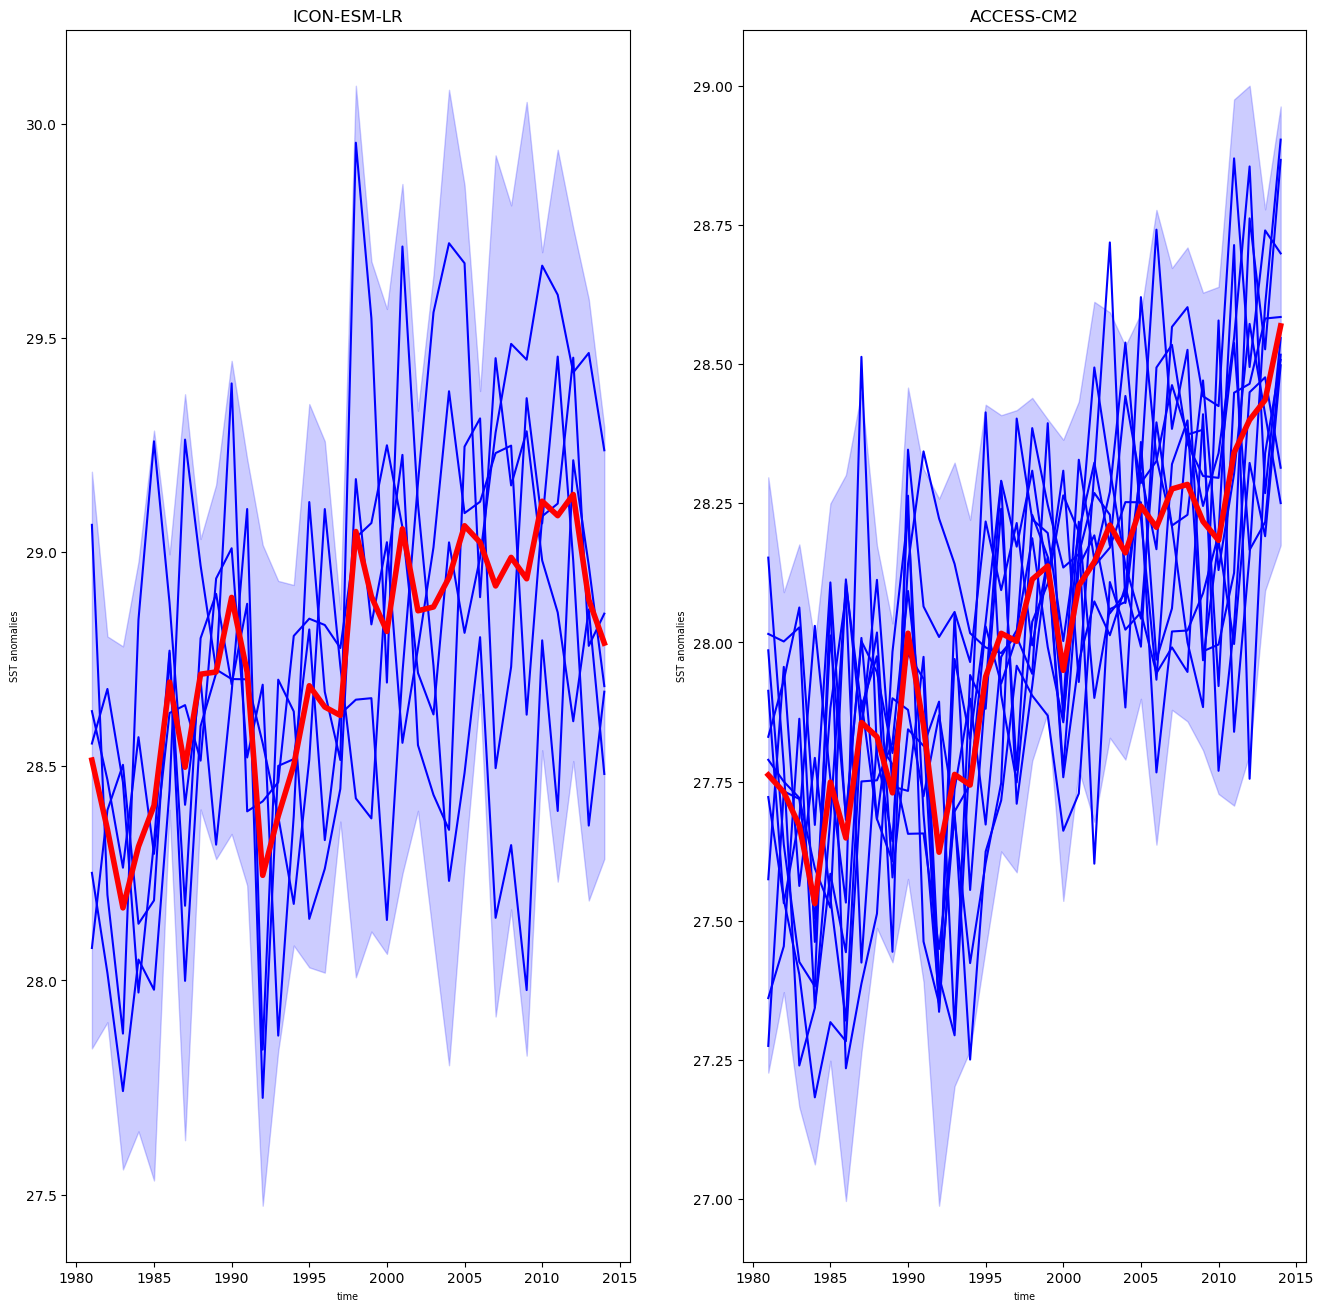

In [7]:
idx_grid_lat = 20
idx_grid_lon = 50

vars_tmp0 = vars[m0].reshape(time_period,lat_size,lon_size)
vars_tmp1 = vars[m1].reshape(time_period,lat_size,lon_size)

fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(1, 2, 1)  
for i in range(sst_to_plot0.shape[0]):
    ax0.plot(times_to_plot,sst_to_plot0[i,:,idx_grid_lat,idx_grid_lon],'b')

# ax0.errorbar(times_to_plot,sst_mean_to_plot0, np.sqrt(variance_processed_ssp585[m].detach().numpy()))

ax0.fill_between(times_to_plot, sst_mean_to_plot0[:,idx_grid_lat,idx_grid_lon]-1.98*np.sqrt(vars_tmp0[:,idx_grid_lat,idx_grid_lon]), sst_mean_to_plot0[:,idx_grid_lat,idx_grid_lon]+1.98*np.sqrt(vars_tmp0[:,idx_grid_lat,idx_grid_lon]), color='blue', alpha=0.2)
ax0.plot(times_to_plot,sst_mean_to_plot0[:,idx_grid_lat,idx_grid_lon],'r',linewidth=4)
ax0.set_title(m0)
ax0.set_xlabel(r'time', size=7)
ax0.set_ylabel(r'SST anomalies', size=7)

ax0 = fig0.add_subplot(1, 2, 2)  
for i in range(sst_to_plot1.shape[0]):
    ax0.plot(times_to_plot,sst_to_plot1[i,:,idx_grid_lat,idx_grid_lon],'b')
ax0.fill_between(times_to_plot, sst_mean_to_plot1[:,idx_grid_lat,idx_grid_lon]-1.98*np.sqrt(vars_tmp1[:,idx_grid_lat,idx_grid_lon]), sst_mean_to_plot1[:,idx_grid_lat,idx_grid_lon]+1.98*np.sqrt(vars_tmp1[:,idx_grid_lat,idx_grid_lon]), color='blue', alpha=0.2)
ax0.plot(times_to_plot,sst_mean_to_plot1[:,idx_grid_lat,idx_grid_lon],'r',linewidth=4)
ax0.set_title(m1)
ax0.set_xlabel(r'time', size=7)
ax0.set_ylabel(r'SST anomalies', size=7)

plt.savefig("../figures/MeanSST_models.png")
plt.show()